In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
from torchvision import datasets
from torchvision import transforms
from tqdm import tqdm

from utils import view_samples
from training import train_discriminator, train_generator, make_samples

In [2]:
# For face generation, switch to CelebA dataset
# Download CelebA from http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html or use torchvision if available
# Example: from torchvision.datasets import CelebA
# celeba = CelebA(root='data/', split='train', download=True, transform=transform)

# For now, keeping CIFAR as example, but adapt for faces
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar_train = datasets.CIFAR10(root='data/', download=True, transform=transform)

batch_size = 128
num_workers = 4

# build DataLoaders for CIFAR10 dataset
train_loader = torch.utils.data.DataLoader(dataset=cifar_train,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=num_workers)

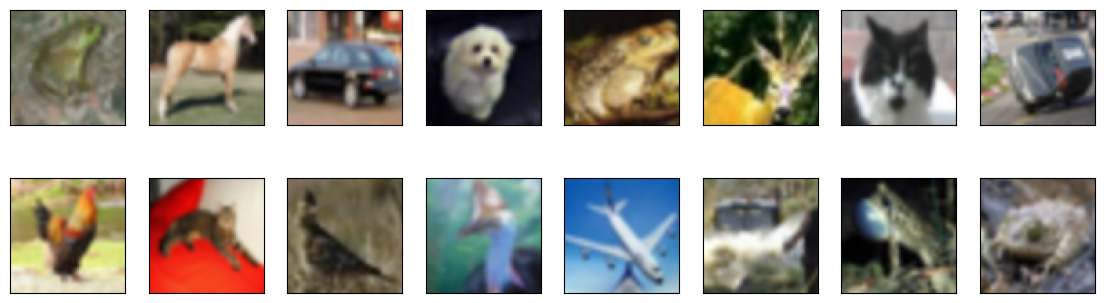

In [3]:
images, _ = next(iter(train_loader))
view_samples(images[:16])

In [4]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, use_batch_norm=True):
        super(ConvBlock, self).__init__()
        self.use_batch_norm = use_batch_norm
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=2,
                              padding = 1, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x) if self.use_batch_norm else x
        return self.activation(x)
    
    
class Discriminator(nn.Module):
    def __init__(self, conv_dim=64, channels=3):  # Increased conv_dim
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            ConvBlock(channels, conv_dim, 4, use_batch_norm=False),
            ConvBlock(conv_dim, conv_dim * 2, 4),
            ConvBlock(conv_dim * 2, conv_dim * 4, 4),
            ConvBlock(conv_dim * 4, conv_dim * 8, 4),  # Extra layer
            
            nn.Flatten(),
            nn.Linear(conv_dim * 8 * 4 * 4, 1)  # Adjusted for 64x64 output
        )
        
    def forward(self, x):
        return self.discriminator(x)

In [5]:
class DeconvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 padding, use_batch_norm=True):
        super(DeconvBlock, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
                                         stride, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        x = self.deconv(x)
        x = self.batch_norm(x) if self.use_batch_norm else x
        return self.activation(x)
    
class Generator(nn.Module):
    def __init__(self, latent_dim, conv_dim=64, channels=3):  # Increased conv_dim for higher res
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.generator = nn.Sequential(
            DeconvBlock(latent_dim, conv_dim * 8, 4, 1, 0),  # More layers for 64x64
            DeconvBlock(conv_dim * 8, conv_dim * 4, 4, 2, 1),
            DeconvBlock(conv_dim * 4, conv_dim * 2, 4, 2, 1),
            DeconvBlock(conv_dim * 2, conv_dim, 4, 2, 1),
            
            nn.ConvTranspose2d(conv_dim, channels, 4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        if x.dim() == 2:
            x = x.view(x.size(0), self.latent_dim, 1, 1)
        return self.generator(x)

In [6]:
conv_dim = 64  # Increased for higher resolution
latent_dim = 128  # Increase latent dimension for more expressive representations
channels = 3

discriminator = Discriminator(conv_dim, channels)
generator = Generator(latent_dim, conv_dim, channels)

gpu = torch.cuda.is_available()
if gpu:
    discriminator.cuda()
    generator.cuda()

In [7]:
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
num_epochs = 50  # Increase from 10 to 50 for better convergence

disc_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))
gen_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

In [ ]:
for epoch in range(num_epochs):
    for real_images, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch_size = real_images.size(0)
        
        # Train the discriminator
        disc_loss = train_discriminator(real_images, discriminator, disc_optimizer, 
                                        generator, latent_dim, gpu)
        
        # Train the generator
        gen_loss = train_generator(discriminator, generator, gen_optimizer, batch_size, 
                                   latent_dim, gpu, channels=3)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"D Loss: {disc_loss:.4f}, G Loss: {gen_loss:.4f}")
    
    # Generate and view samples
    if (epoch + 1) % 10 == 0:  # Generate samples every 10 epochs to monitor progress
        samples = make_samples(generator, 16, latent_dim, channels=3, gpu=gpu)
        view_samples(samples)

Epoch 1/50: 100%|██████████| 391/391 [18:11<00:00,  2.79s/it]


Epoch [1/50], D Loss: 0.5113, G Loss: 3.6609


Epoch 2/50:  13%|█▎        | 49/391 [02:34<16:56,  2.97s/it] 